In [1]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
import re
import csv
import itertools
import numpy as np

In [3]:
def load_data(path, limit=None):
    with open(path, encoding = 'utf8') as file:
        reader = csv.reader(file, delimiter=',')
        # get header
        header = next(reader)
        data = np.asarray([[value for value in row] for row in itertools.islice(reader, limit)])
    return header, data

In [4]:
header, data = load_data("data/training.csv", limit=100000)

In [5]:
print(header)

['Date/Hour', 'Temperature (°C)', 'Drew point (°C)', 'Relativite humidity (%)', 'wind direction (10s deg)', 'Wind speed (km/h)', 'Visibility (km)', 'Visility indicator', 'Pressure at the station (kPa)', 'hmdx', 'Wind Chill', 'Weather', 'Public Holiday', 'Station Code', 'Withdrawals', 'Volume']


# I. Data preprocessing

### I.1. Remove features with mostly missing values

In [6]:
def print_sample(header, data, n=0):
    for i, (feature, value) in enumerate(zip(header, data[n])):
        print("({:^2d}) {:30} : {}".format(i, feature, value))

In [7]:
def print_feature(header, data, max_feature=5):
    for n_feature, feature in enumerate(data.T):
        values, counts = np.unique(feature, return_counts=True)
        counts_values = sorted(zip(counts, values), reverse=True)
        print("-" * 50)
        print("({:02d}) {} ({})".format(n_feature, header[n_feature], len(values)))
        print("-" * 50)
        for i, (v, c) in enumerate(counts_values):
            if i > max_feature:
                break
            print("{:10} : {:10} ({:5.1%})".format(c, v, v / data.shape[0]))

In [8]:
print_feature(header, data)

--------------------------------------------------
(00) Date/Hour (8497)
--------------------------------------------------
2016-07-20 04:00 :         24 ( 0.0%)
2016-06-19 07:00 :         24 ( 0.0%)
2016-05-26 15:00 :         24 ( 0.0%)
2015-10-25 20:00 :         24 ( 0.0%)
2015-04-24 03:00 :         24 ( 0.0%)
2016-08-30 07:00 :         23 ( 0.0%)
--------------------------------------------------
(01) Temperature (°C) (358)
--------------------------------------------------
21,1       :        754 ( 0.8%)
21,0       :        748 ( 0.7%)
19,5       :        737 ( 0.7%)
19,0       :        723 ( 0.7%)
21,5       :        713 ( 0.7%)
20,3       :        697 ( 0.7%)
--------------------------------------------------
(02) Drew point (°C) (372)
--------------------------------------------------
16,0       :        893 ( 0.9%)
15,3       :        857 ( 0.9%)
16,2       :        855 ( 0.9%)
17,7       :        799 ( 0.8%)
14,5       :        782 ( 0.8%)
13,8       :        782 ( 0.8%)
-----

 * We can remove the feature without values in over 50% of samples. 

 * We decide to keep Weather as it is discrete and we can easily replace it with a one-hot vector. 

 * We also need to remove Withdrawals that is not available in test data.

In [9]:
data = np.delete(data, [7, 9, 10, 14], 1)
header = np.delete(header, [7, 9, 10, 14])

### I.2 Convert Date to Year, Month, Day, Hour

In the date we can extract several informations : the Year, the Month, the day, and the hour.

From this, we can also deduce a useful information : the day of the week (if it's Monday, Tuesday, etc.).

In [10]:
import datetime

In [11]:
def convert_date(data, index):
    new_data = []
    for i, d in enumerate(data):
        dt = datetime.datetime.fromisoformat(d[index])
        new_data.append([dt.year, dt.month, dt.day, dt.hour] + 
                        [int(dt.date().weekday() == i) for i in range(7)] + 
                        list(d[index + 1:]))
#         new_data.append(
#             re.split('-| |:|', d[index])[:-1] + list(d[index + 1:]))
    return np.asarray(new_data)

In [12]:
index_date = 0
data = convert_date(data, index_date)
date_header = ["Year", "Month", "Day", "Hour", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
header = date_header + list(header[index_date + 1:])

In [13]:
print(len(header))
print(data.shape)
print(header)

22
(100000, 22)
['Year', 'Month', 'Day', 'Hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Temperature (°C)', 'Drew point (°C)', 'Relativite humidity (%)', 'wind direction (10s deg)', 'Wind speed (km/h)', 'Visibility (km)', 'Pressure at the station (kPa)', 'Weather', 'Public Holiday', 'Station Code', 'Volume']


### I.3 Convert Weather to binary vector

In [14]:
def convert_weather(data, weather, index):
    N = len(weather)
    new_data = []
    for i, d in enumerate(data):
        new_weather = [
            1 if any([w == v for v in d[index].split(',')]) else 0
            for w in weather
        ]
        new_data.append(list(d[:index]) + new_weather + list(d[index + 1:]))
    return np.asarray(new_data)

In [15]:
index_weather = header.index("Weather")
set(l for s in set(data.T[index_weather]) for l in s.split(","))

{'',
 'Averses de neige',
 'Averses de pluie',
 'Averses de pluie forte',
 'Averses de pluie modérées',
 'Brouillard',
 'Bruine',
 'Dégagé',
 'Généralement dégagé',
 'Généralement nuageux',
 'ND',
 'Neige',
 'Nuageux',
 'Orages',
 'Pluie',
 'Pluie forte',
 'Pluie modérée'}

In [16]:
weather = [
    'Orages', 'Brouillard', 'Bruine', 'Généralement dégagé',
    'Généralement nuageux', 'Pluie', 'Pluie modérée', 'Pluie forte', 'Dégagé',
    'Nuageux', 'Neige'
]
data = convert_weather(data, weather, index_weather)
header = list(header[:index_weather]) + weather + list(
    header[index_weather + 1:])

### I.4 Convert feature type from string to float (remove samples with missing values)

In [17]:
# samples with at least one missing value
missing = [d for d in data if '' in d]
print(len(missing))

# number of class 1 with missing value
print(sum(['1' in d[-1] for d in missing]))

141
15


Let's remove the samples with missing values as only one hundred have label 1.

In [18]:
def convert_type(data):
    return np.asarray(
        [[float(v.replace(",", ".")) for v in d] for d in data if "" not in d])

In [19]:
data = convert_type(data)

In [20]:
print_sample(header, data, 8716)

(0 ) Year                           : 2016.0
(1 ) Month                          : 8.0
(2 ) Day                            : 16.0
(3 ) Hour                           : 19.0
(4 ) Monday                         : 0.0
(5 ) Tuesday                        : 1.0
(6 ) Wednesday                      : 0.0
(7 ) Thursday                       : 0.0
(8 ) Friday                         : 0.0
(9 ) Saturday                       : 0.0
(10) Sunday                         : 0.0
(11) Temperature (°C)               : 18.6
(12) Drew point (°C)                : 17.8
(13) Relativite humidity (%)        : 95.0
(14) wind direction (10s deg)       : 5.0
(15) Wind speed (km/h)              : 29.0
(16) Visibility (km)                : 1.2
(17) Pressure at the station (kPa)  : 100.56
(18) Orages                         : 0.0
(19) Brouillard                     : 1.0
(20) Bruine                         : 0.0
(21) Généralement dégagé            : 0.0
(22) Généralement nuageux           : 0.0
(23) Pluie            

In [21]:
print(data.shape)

(99859, 32)


# Data analysis & visualization

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def plot_features(header, data):
    cols = 4
    n = data.shape[1] // cols
    fig, ax = plt.subplots(nrows=n, ncols=cols, figsize=(cols * 6, n * 6))
    for i, (name, feature) in enumerate(zip(header, data.T)):
        ax[i // cols, i % cols].hist(feature)
        ax[i // cols, i % cols].set_title(name)
    plt.show()

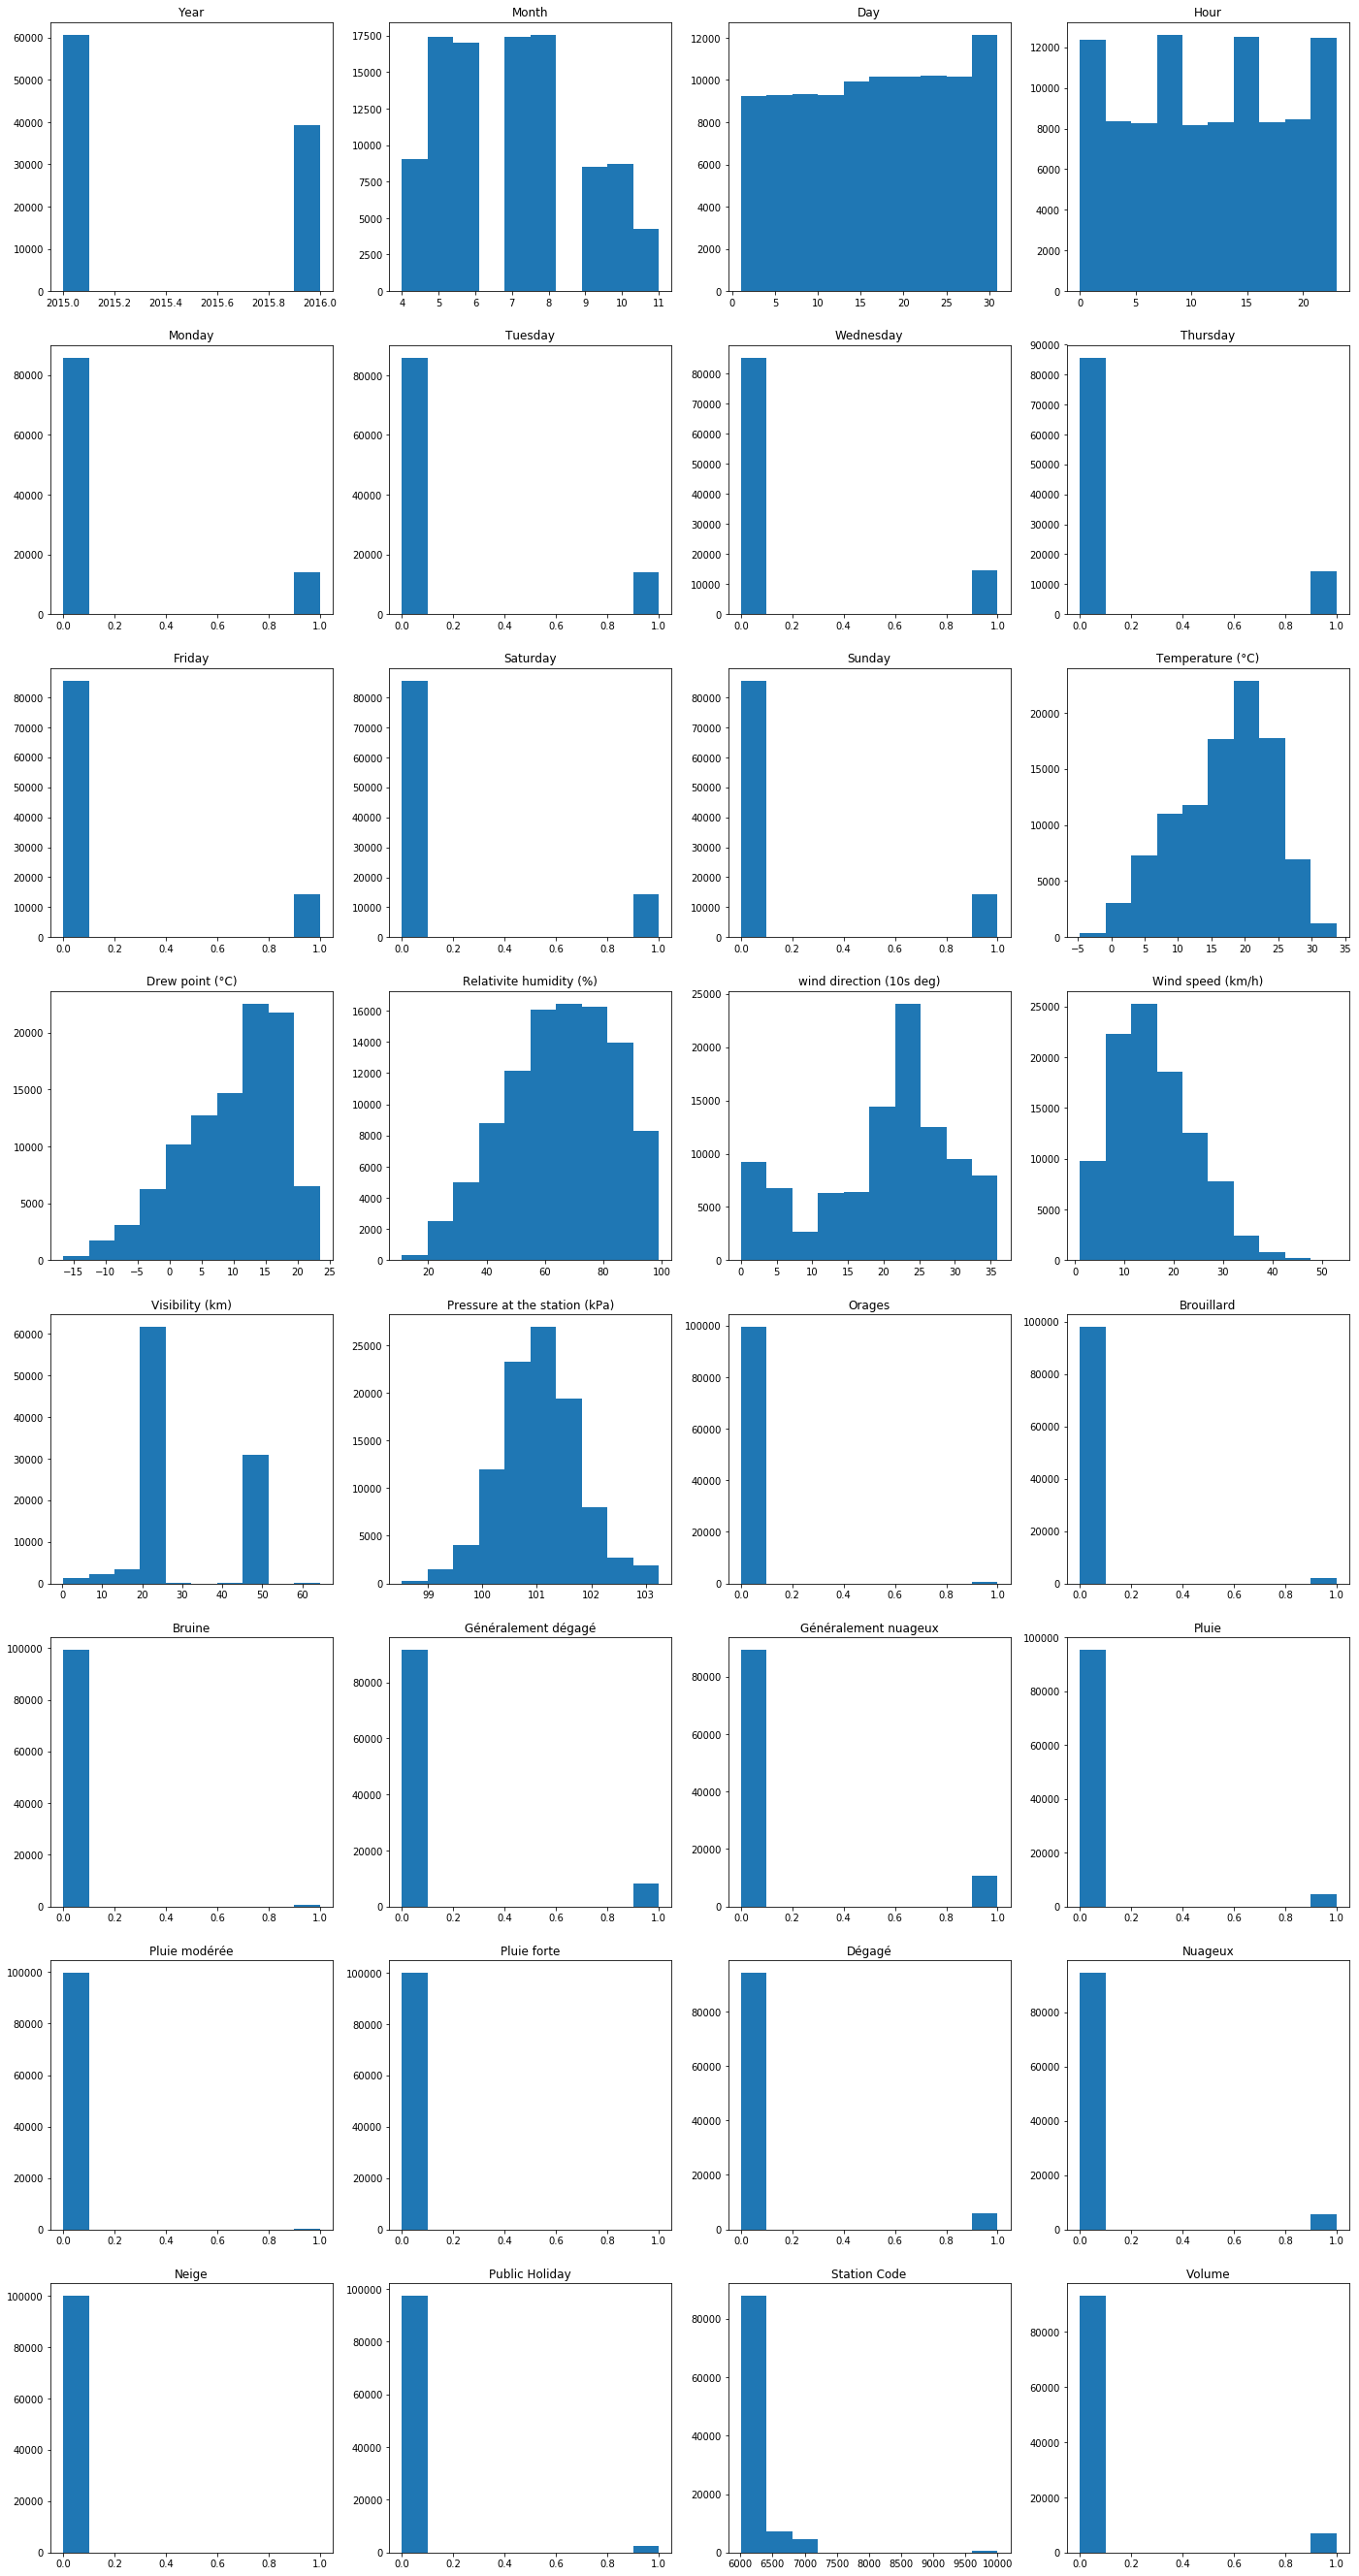

In [26]:
plot_features(header, data)

In [23]:
def feature_output_corr(header, data):
    coeff = [np.corrcoef(feature, data.T[-1])[0][1] for feature in data.T[:-1]]
    abs_coeff = list(map(abs, coeff))
    for _, coeff, name in sorted(zip(abs_coeff, coeff, header), reverse=True):
        print("{:30} : {:6.3f}".format(name, coeff))

In [24]:
feature_output_corr(header, data)

Temperature (°C)               :  0.197
Relativite humidity (%)        : -0.163
Hour                           :  0.147
Visibility (km)                :  0.138
Drew point (°C)                :  0.074
Wind speed (km/h)              :  0.059
Year                           :  0.055
Pluie                          : -0.052
Brouillard                     : -0.036
Dégagé                         : -0.033
Station Code                   : -0.031
wind direction (10s deg)       :  0.023
Pressure at the station (kPa)  : -0.017
Bruine                         : -0.017
Nuageux                        : -0.017
Month                          : -0.016
Pluie modérée                  : -0.012
Neige                          : -0.008
Généralement dégagé            :  0.008
Généralement nuageux           :  0.007
Orages                         : -0.006
Pluie forte                    : -0.005
Public Holiday                 : -0.004
Day                            :  0.003


# Models

In [25]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [26]:
def compute_f1(proba, y_true, step=0.01, plot=False):
    f1 = []

    for threshold in np.arange(0, 1, step):
        y_pred = [int(y > threshold) for y in proba]
        f1.append(f1_score(y_test, y_pred) if 1 in y_pred else 0)

    if plot:
        plt.figure(figsize=(6, 4), dpi=300)
        plt.plot(np.arange(0, 1, step), f1)
        plt.xlabel('Threshold')
        plt.ylabel('F1-score')
        plt.show()

    return max(f1), step * np.argmax(f1)

In [27]:
x, y = data[:, :-1], data[:, -1]
split = int(data.shape[0] * 0.8)
x_train, x_test, y_train, y_test = data[:split, :-1], data[
    split:, :-1], data[:split, -1], data[split:, -1]

### Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
model = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: 6})
model = model.fit(x_train, y_train)

In [30]:
prediction = model.predict_proba(x_test)
proba = list(zip(*prediction))[1]

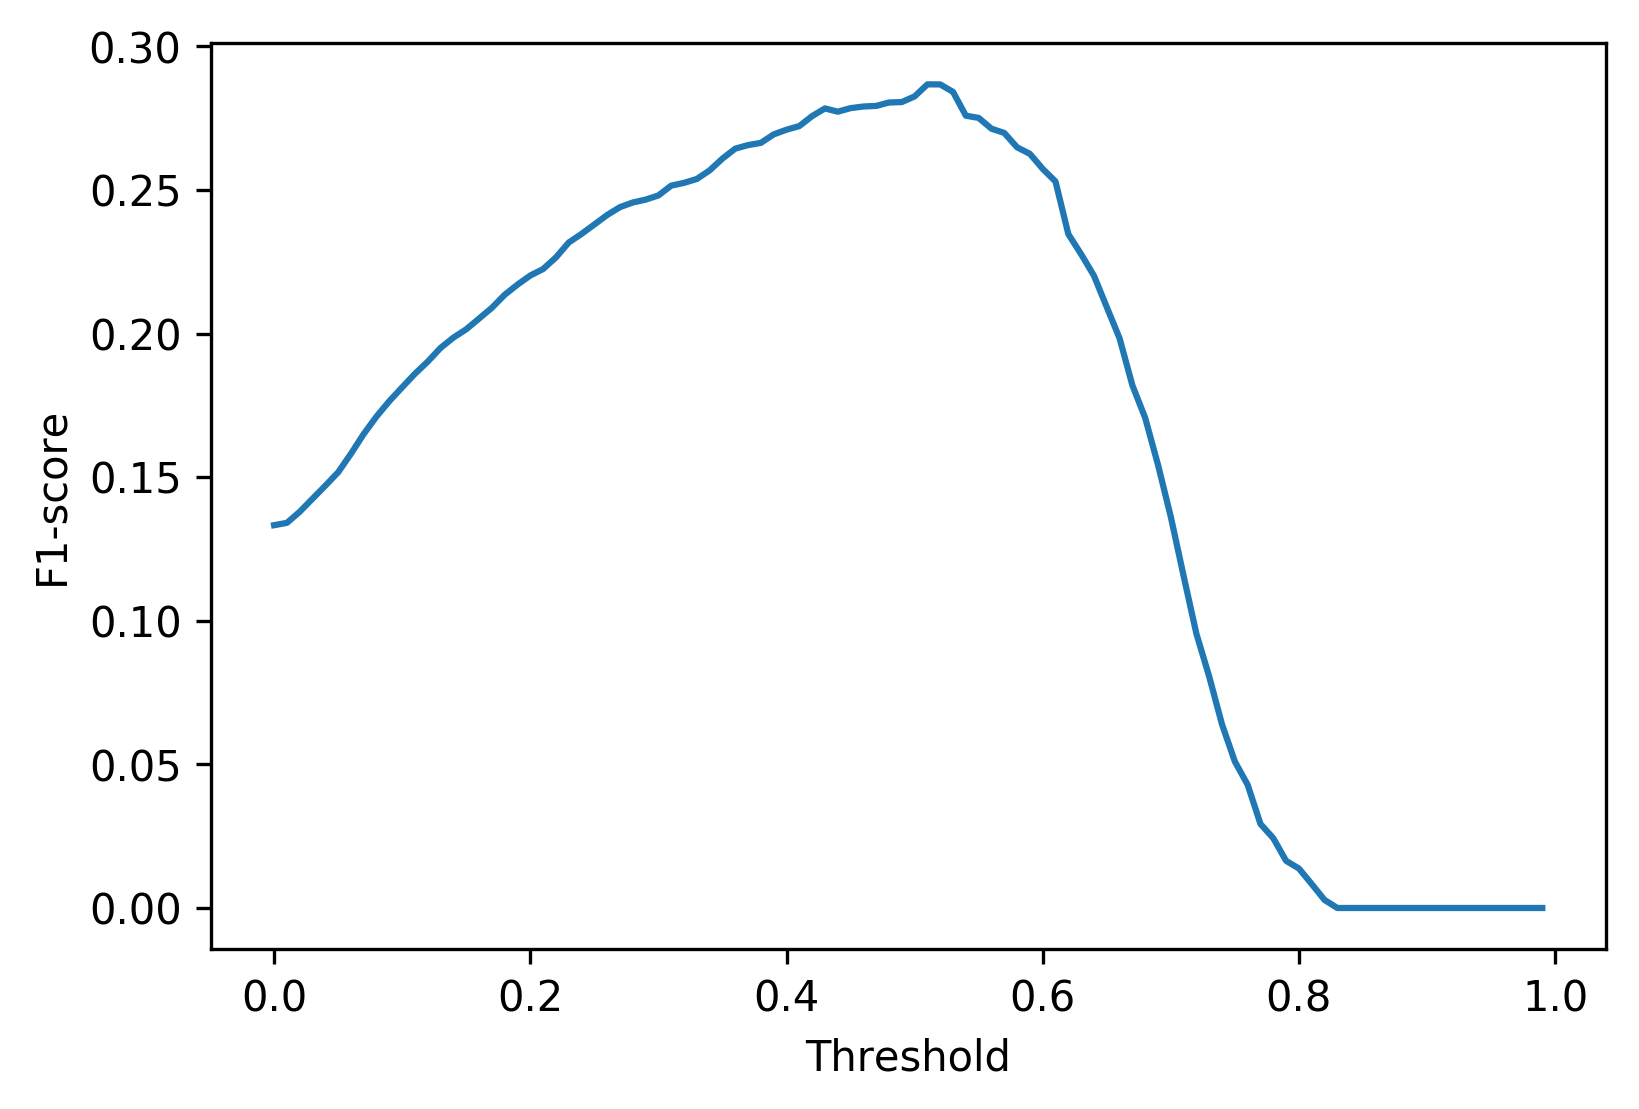

(0.28677921508441134, 0.51)

In [31]:
compute_f1(proba, y_test, plot=True)